# DeepSensor's plotting functionality

DeepSensor provides a few helpful plotting methods. This notebook demonstrates how to use each one.

## Set up

In [1]:
import deepsensor.tensorflow as deepsensor
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.models import ConvNP

import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

2023-06-22 13:44:26.662979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 13:44:26.881694: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


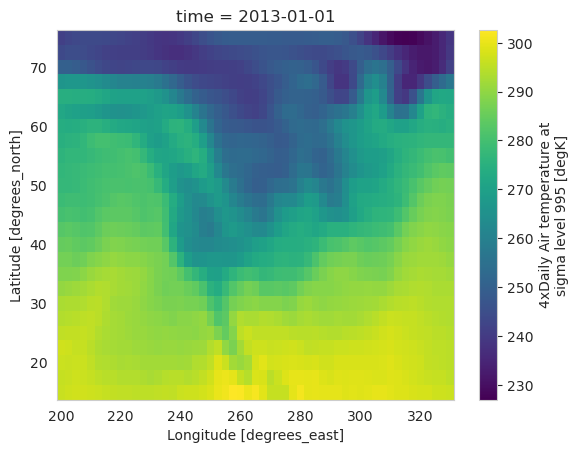

In [2]:
# Load raw data and visualise a slice
ds_raw = xr.tutorial.open_dataset("air_temperature")
ds_raw.isel(time=0).air.plot()

In [3]:
# Normalise data
data_processor = DataProcessor(x1_name="lat", x1_map=(ds_raw["lat"].min(), ds_raw["lat"].max()), x2_name="lon", x2_map=(ds_raw["lon"].min(), ds_raw["lon"].max()))
ds = data_processor(ds_raw)

In [4]:
# Set up task loader
task_loader = TaskLoader(context=ds, target=ds)

In [5]:
# Set up model
model = ConvNP(data_processor, task_loader, verbose=False)

2023-06-22 13:44:47.335545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13163 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:98:00.0, compute capability: 8.6


In [26]:
# Predict on a task to compile model and get a prediction
task = task_loader("2014-12-31", context_sampling=0.1)

In [14]:
mean_ds, std_ds = model.predict(task, X_t=ds_raw)

## Model receptive field

The use of a convolutional architecture (U-Net) in the `ConvNP` model means that the model has a receptive field. This is the area of the input data that influences the prediction at a given point. The receptive field is a function of the U-Net architecture, such as number of layers, filter size, and internal discretisation density.

The receptive field can be visualised using the `receptive_field` method of the `deepsensor.plot` module. This will unnormalise the receptive field and plot it on a map of the globe, which can be useful for understanding the spatial extent of the receptive field.

Some things to consider are:
* Is the receptive field too large (i.e. larger than the range of context and target data)? This can cause excessive zero-padding.
* Is the receptive field too small (i.e. smaller than the range of correlation between context and target data)?

You can increase/decrease the receptive field by:
* Increasing/decreasing the number of layers in the U-Net
* Increasing/decreasing the filter size in the U-Net
* Decreasing/increasing the internal discretisation density of the U-Net
Note that the first two options will also affect the number of parameters in the model. To mitigate this, the number of channels in the U-Net (which has no effect on receptive field) can be adjusted.

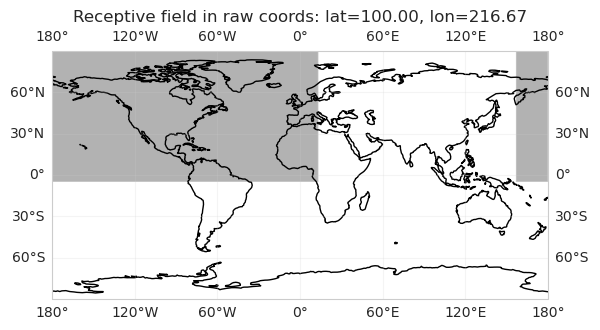

In [15]:
fig = deepsensor.plot.receptive_field(model.model.receptive_field, data_processor, crs=ccrs.PlateCarree())

## Context encoding

Inspecting the gridded encoding of the context data (output by the SetConv component of a `ConvNP` object)
This can help with understanding the `context_sampling` schemes provided by the `TaskLoader`.

This can also be an extremely useful debugging tool. For example:
* Do the length scales of the encoded data seem reasonable (i.e. avoids blurring high frequency components while not being so small to induce checkerboard artefacts)?
* Are the channel magnitudes in the encoding reasonable?
* Are there any `nan` values?


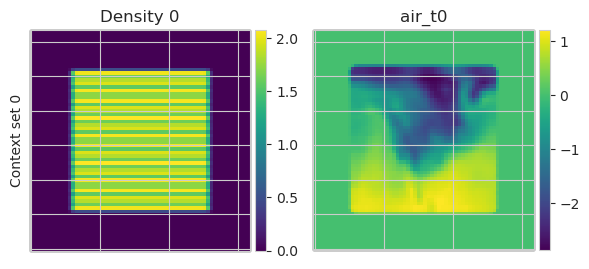

In [19]:
fig = deepsensor.plot.context_encoding(model, task_loader("2014-12-31", context_sampling="all"), task_loader)

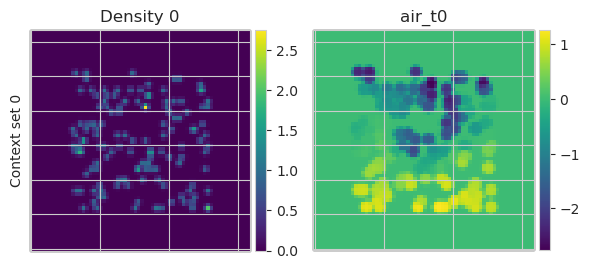

In [23]:
fig = deepsensor.plot.context_encoding(model, task_loader("2014-12-31", context_sampling=0.1), task_loader)

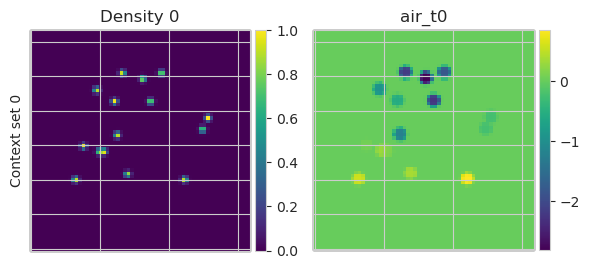

In [25]:
fig = deepsensor.plot.context_encoding(model, task_loader("2014-12-31", context_sampling=15), task_loader)

## Feature maps

Visualising the internal feature maps (also known as activation maps) can provide some insight into the internal workings of the model.
DeepSensor provides a method for plotting a few randomly selected feature maps after each layer of the U-Net component of a `ConvNP` model object.

Some things to consider are:
* Are the shapes of the feature maps as expected?
* Are the min and max values of the feature maps reasonable?
* Are many of the channels zero?

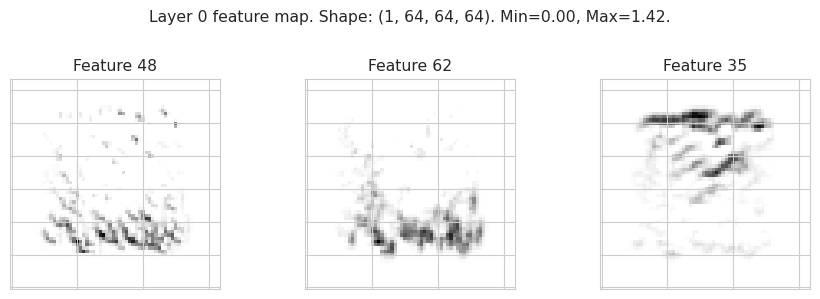

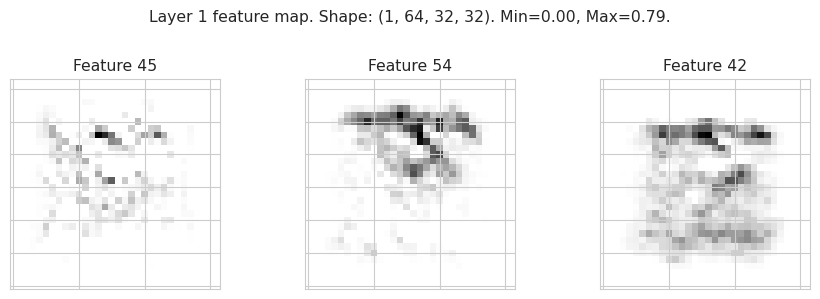

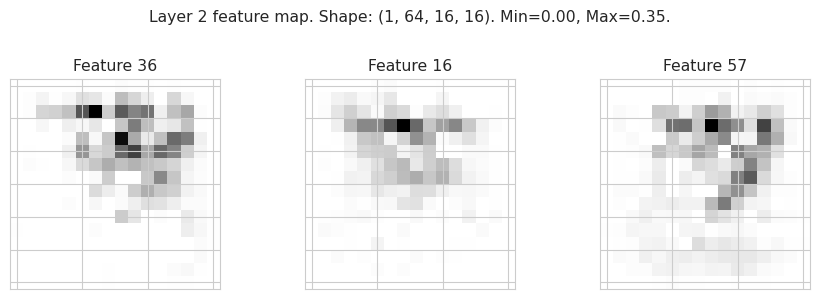

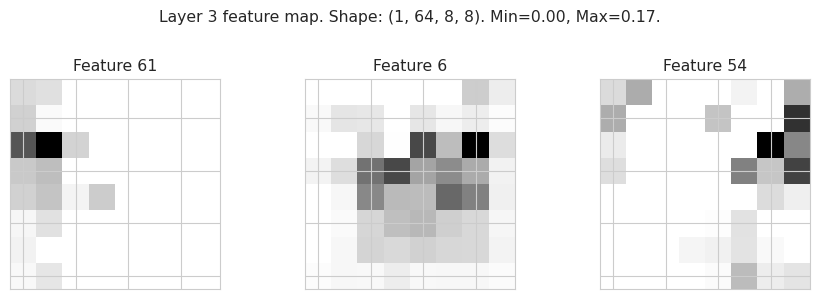

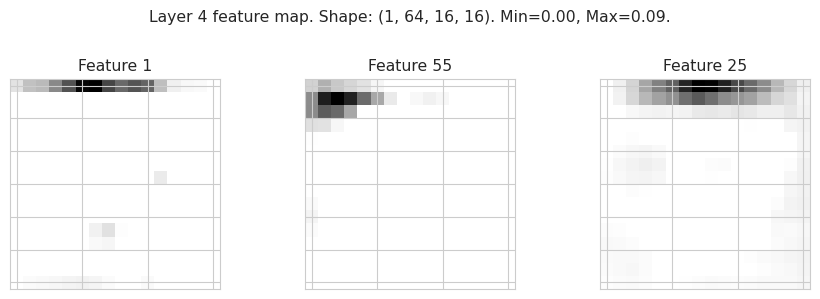

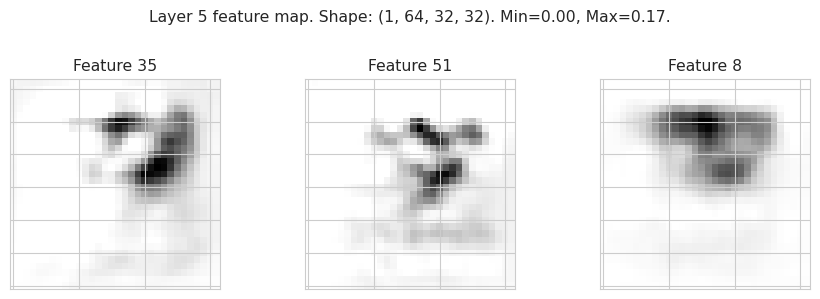

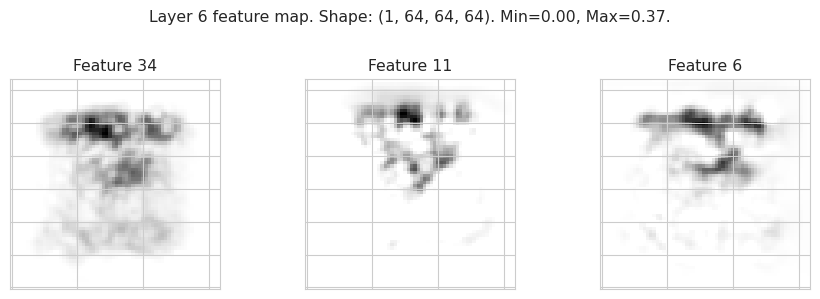

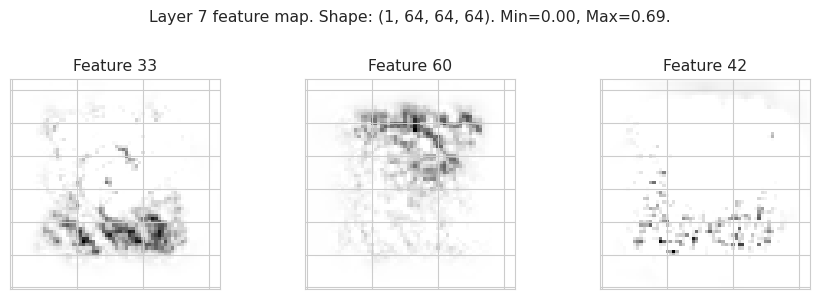

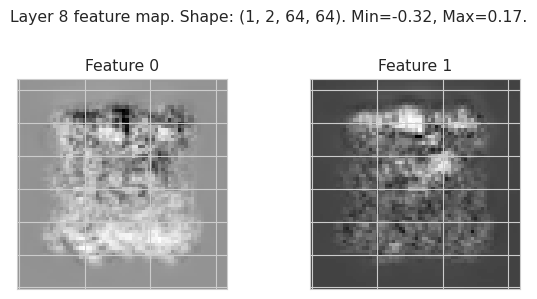

In [27]:
figs = deepsensor.plot.feature_maps(model, task, 3)

## Model prediction with off-grid context scatter points

When visualising model predictions, it is often useful to show the locations of point-based context data points. This can be done using the `offgrid_context` method of the `deepsensor.plot` module. This method will automatically plot non-gridded context sets from the `Task` object.

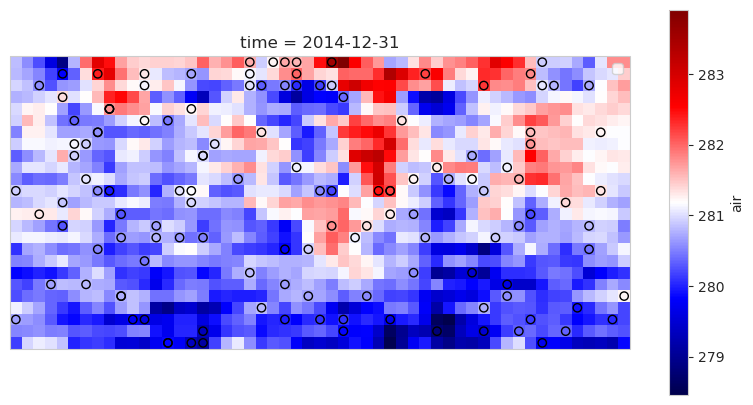

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
mean_ds.isel(time=0).air.plot(cmap='seismic', ax=ax, transform=ccrs.PlateCarree())
deepsensor.plot.offgrid_context(ax, task, data_processor, task_loader)

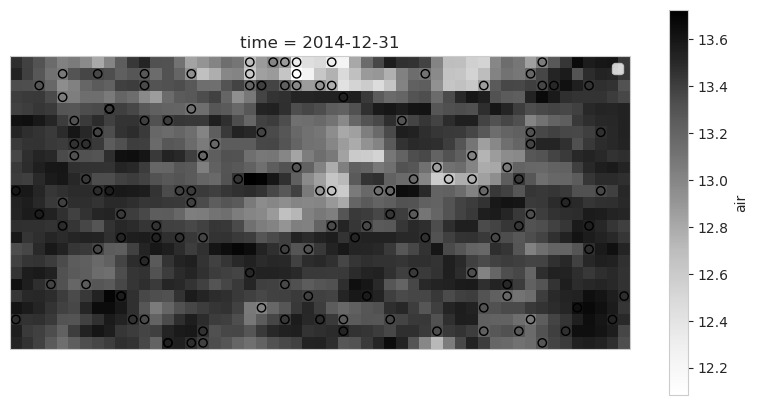

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
std_ds.isel(time=0).air.plot(cmap='Greys', ax=ax, transform=ccrs.PlateCarree())
deepsensor.plot.offgrid_context(ax, task, data_processor, task_loader)